# Práctica Final
**Autor: Jorge Vázquez Pérez**

In [13]:
#%pip install qiskit
#%pip install graphviz

from qiskit import QuantumCircuit, transpile, execute
from qiskit_aer import Aer
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit.providers.fake_provider import FakeLimaV2
from qiskit.visualization import plot_gate_map

from qiskit_ibm_provider import IBMProvider
import qiskit.tools.jupyter

IBMProvider.save_account('368ce8e3d58876f8744c71270f2727fd9883b04d75ad646fa5f7345d0b9dede6f06cdc12ebf7e0d0db8a2f0881369da230f432512437401e11ae29dd202b9561', overwrite=True)

%qiskit_version_table

En primer lugar, comenzamos construyendo el circuito deseado, este circuito se corresponde con el circuíto del algoritmo de Berstein-Varizani de 5 qubits.

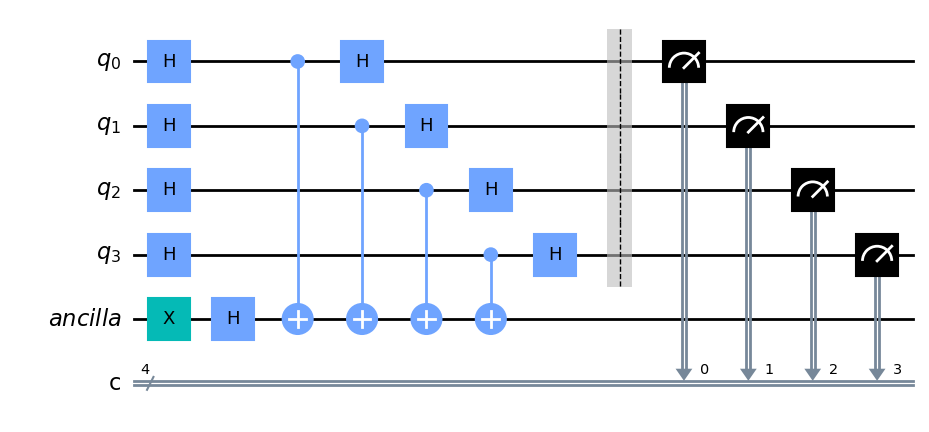

In [14]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
 
qr = QuantumRegister(4, 'q')
anc = QuantumRegister(1, 'ancilla')
cr = ClassicalRegister(4, 'c')
qc = QuantumCircuit(qr, anc, cr)
 
qc.x(anc[0])
qc.h(anc[0])
qc.h(qr[0:4])
qc.cx(qr[0:4], anc[0])
qc.h(qr[0:4])
qc.barrier(qr)
qc.measure(qr, cr)
 
qc.draw('mpl')

Ahora, ejecutamos el circuíto simulando el comportamiento ideal con Aer. Seleccionaremos el backend por defecto de Aer, haciendo que él automáticamente seleccione el más adecuado.

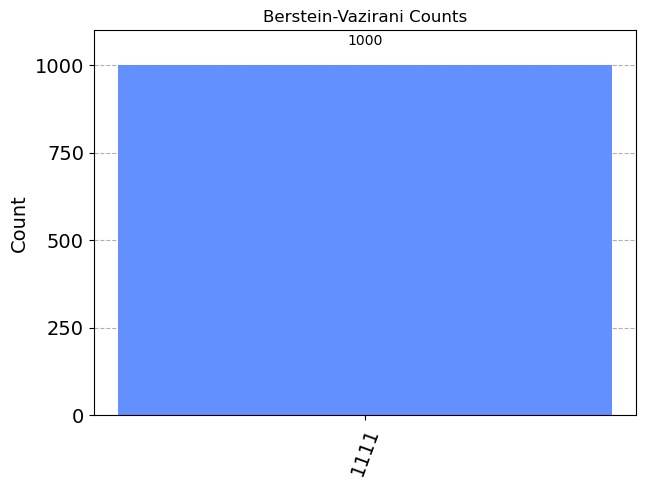

In [15]:
shots=1000

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator') # automatic simulation method
tqc = transpile(qc, simulator)

# Run and get counts
counts = execute(tqc, simulator, shots=shots).result().get_counts()
display(plot_histogram(counts, title='Berstein-Vazirani Counts'))

Ahora, ejecutamos en el computador cuántico real con menos carga de trabajo de IBM.

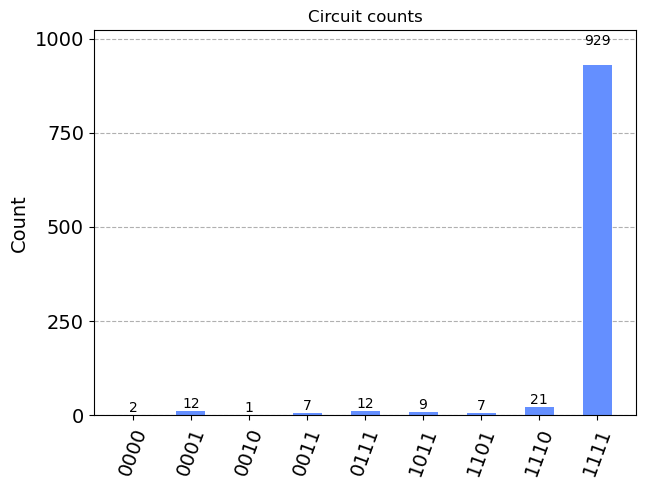

In [16]:
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_provider import least_busy

provider = IBMProvider()
shots = 1000

# Transpile for real quantum computer
devices = provider.backends(simulator=False, operational=True)
real_backend = least_busy(devices)

noise_model_real = NoiseModel.from_backend(real_backend)
bases_gates_real = real_backend.basis_gates
coupling_map_real = real_backend.coupling_map
noise_simulator_backend = Aer.get_backend("aer_simulator")

tqc = transpile(qc, real_backend)

# Run and get counts
counts_real = execute(tqc, noise_simulator_backend, noise_model=noise_model_real, basis_gates=bases_gates_real, coupling_map=coupling_map_real, shots=shots).result().get_counts()
display(plot_histogram(counts_real, title='Circuit counts'))

Vemos como a diferencia del caso ideal, la distribución de probabilidad no se acumula únicamente en el resultado $|1111\rangle$. Ahora, apliquemos diferentes técnicas de mitigación y supresión de errores.

/home/jorge.vazquez.perez/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


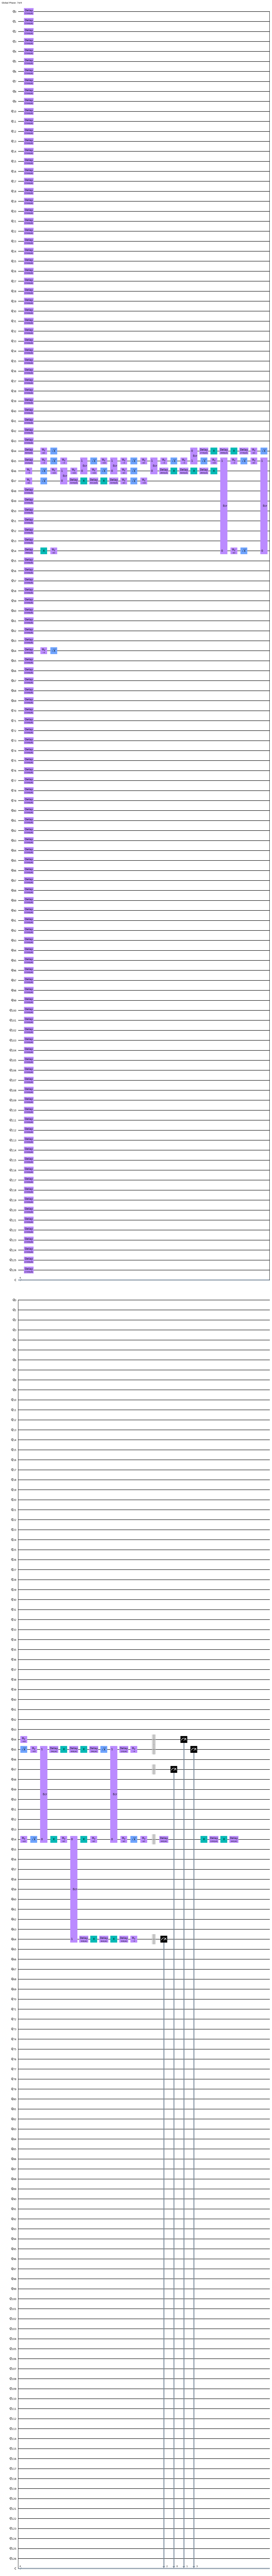

In [17]:
from qiskit.transpiler import InstructionDurations
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling

#Obtengo la duración de sus intrucciones y las restricciones temporales
durations = InstructionDurations.from_backend(real_backend)
constraints = real_backend.configuration().timing_constraints

dd_sequence = [XGate(), XGate()]
pm = PassManager([ALAPScheduleAnalysis(durations),
                  PadDynamicalDecoupling(durations, dd_sequence, pulse_alignment=constraints['pulse_alignment'])])

#Hay que aplicarlo al circuito transpilado
qc_dd = pm.run(tqc)
qc_dd.draw("mpl")

Ejecutemos el circuito resultante tras haber aplicado el desacoplamiento dinámico.

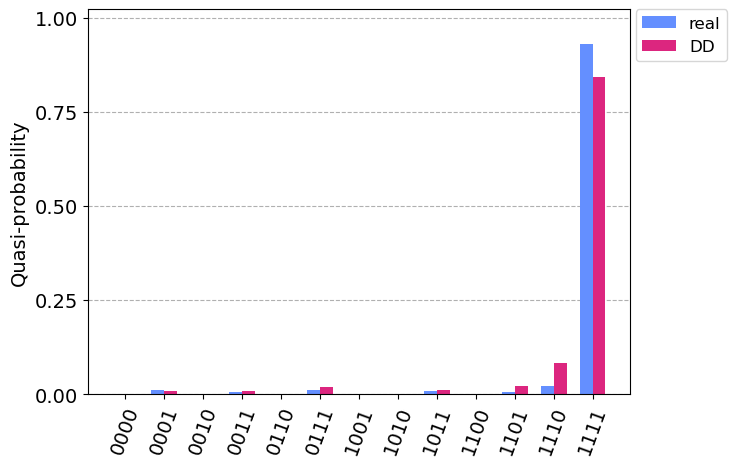

In [18]:
tqc_dd = transpile(qc_dd, real_backend)
counts_dd = execute(tqc_dd, noise_simulator_backend, noise_model=noise_model_real, basis_gates=bases_gates_real, coupling_map=coupling_map_real, shots=shots).result().get_counts()

plot_distribution([counts_real, counts_dd],legend=['real', 'DD'], bar_labels=False)

Vemos que la supresión de errores, de hecho, tiene una eficiencia menor que el ordenador real con ningún tipo de corrección de errores. Apliquemos ahora mitigación de errores para ver su efecto.

/home/jorge.vazquez.perez/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


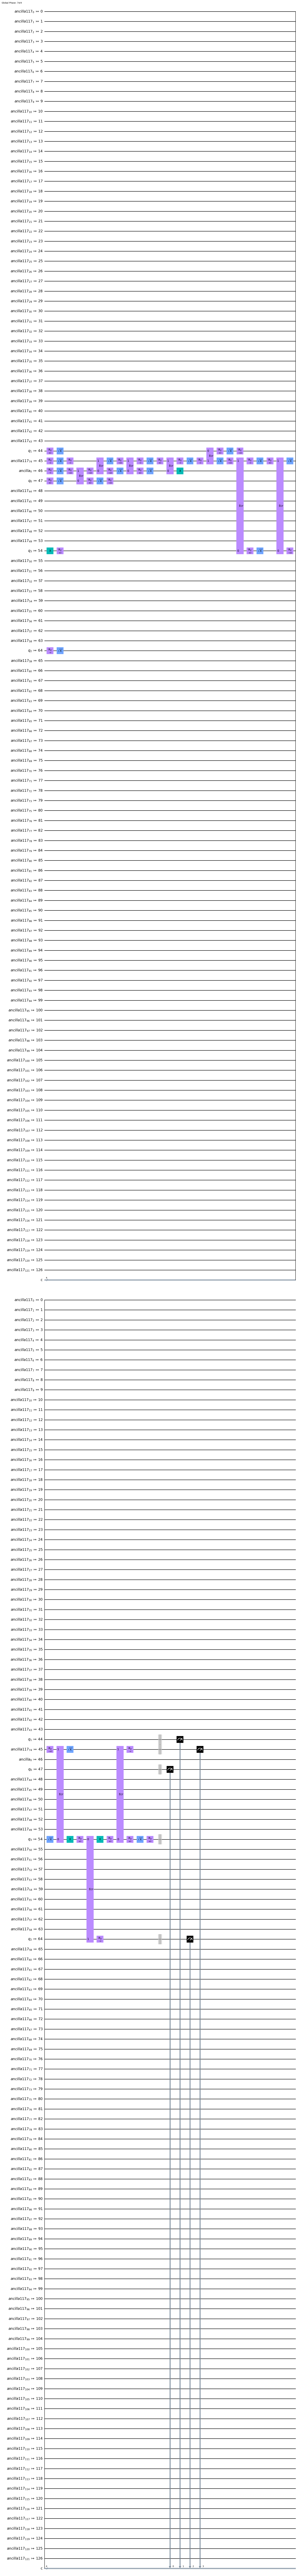

In [19]:
tqc.draw('mpl')

In [25]:
from qiskit_experiments.library import CorrelatedReadoutError

#Inicializo el experimento
physical_qubits=[0,1,2,3]
exp=CorrelatedReadoutError(physical_qubits, real_backend)

exp_data=exp.run(noise_simulator_backend,shots=1000)
mitigator=exp_data.analysis_results(0).value
quasi_prob_mitigated=mitigator.quasi_probabilities(counts,physical_qubits).binary_probabilities()
counts_mit = {key: value * shots for key, value in quasi_prob_mitigated.items()}

print(counts_mit)

{'0000': 0.0, '0001': 0.0, '0010': 0.0, '0011': 0.0, '0100': 0.0, '0101': 0.0, '0110': 0.0, '0111': 0.0, '1000': 0.0, '1001': 0.0, '1010': 0.0, '1011': 0.0, '1100': 0.0, '1101': 0.0, '1110': 0.0, '1111': 1000.0}
{'0000': 0.0, '0001': 0.0, '0010': 0.0, '0011': 0.0, '0100': 0.0, '0101': 0.0, '0110': 0.0, '0111': 0.0, '1000': 0.0, '1001': 0.0, '1010': 0.0, '1011': 0.0, '1100': 0.0, '1101': 0.0, '1110': 0.0, '1111': 1.0}


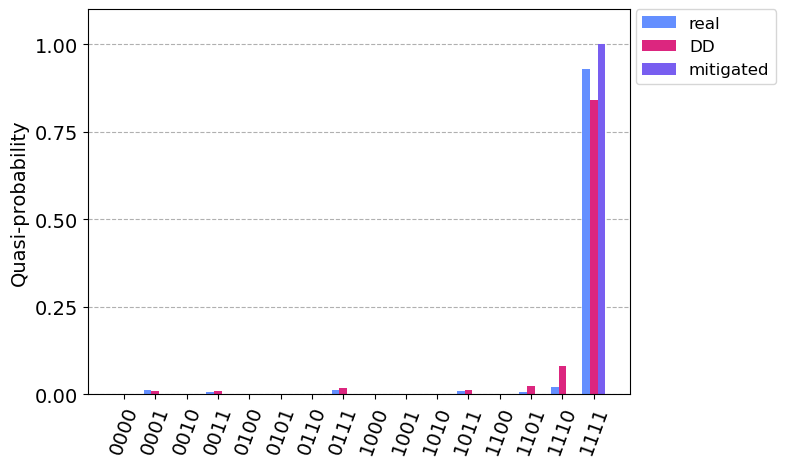

In [26]:
plot_distribution([counts_real, counts_dd, counts_mit],legend=['real', 'DD', 'mitigated'], bar_labels=False)

Ahora, para finalizar, emplearemos el Samler de IBM runtime con diferentes niveles de optimización y resiliencia.

In [38]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit_ibm_provider.job import job_monitor

service = QiskitRuntimeService()

#backend = service.backend(real_backend.name) 
backend = service.backend("ibmq_qasm_simulator") 

job_runtime = Sampler(backend).run(qc, shots=shots)

result = job_runtime.result()
quasi_dists = result.quasi_dists

print("Runtime sampler result: ", result)
print("Runtime sampler quasi_dists: ", quasi_dists[0].binary_probabilities())

TypeError: Invalid parameter values, expected Sequence[Sequence[float]].